#ViT

#1. PREPARACIÓN DE DATOS

In [ ]:
## CARGA DE DATOS
## =============================================================================
!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2228851910684557890, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12979531577697254883
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [ ]:
!pip install --quiet vit-keras

In [ ]:
from vit_keras import vit

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprime en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/ViT/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),                 
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


#IMPLEMENTACIÓN DE PATCHES

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
image_size = 224
patch_size = 16

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


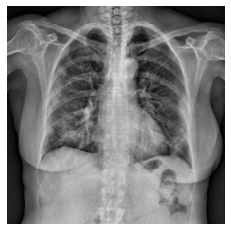

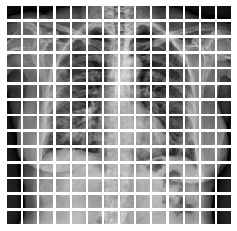

In [ ]:
plt.figure(figsize=(4, 4))

image = train_generator[0][0][0]
plt.imshow(image, interpolation="nearest");
plt.axis("off")

image = np.expand_dims(image, axis=0)
patches = Patches(patch_size)(image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]));
plt.figure(figsize=(4, 4));
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy(), interpolation="nearest")
    plt.axis("off")
plt.show();

#2. CREACIÓN DEL MODELO

In [ ]:
from vit_keras import vit

In [ ]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

vit_model.summary();

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 7, 7, 768)         2360064   
_________________________________________________________________
reshape_15 (Reshape)         (None, 49, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 50, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 50, 768)           38400     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 50, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 50, 768), (None,  7087

In [ ]:
model = Sequential([
        vit_model,
        Flatten(),
        BatchNormalization(),
        Dense(11, activation = 'gelu'),
        BatchNormalization(),
        Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 768)               3072      
_________________________________________________________________
dense_4 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_5 (Batch (None, 11)                44        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 48        
Total params: 87,466,855
Trainable params: 87,465,297
Non-trainable params: 1,558
________________________________

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================
import tensorflow_addons as tfa
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', 
               optimizer= optimizer,
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'ViT_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=30,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ViT_history.npy', history.history)

Epoch 1/30
412/412 [==============================] - 434s 847ms/step - loss: 0.7601 - accuracy: 0.7387 - val_loss: 0.4294 - val_accuracy: 0.8708
Epoch 2/30
412/412 [==============================] - 347s 841ms/step - loss: 0.3948 - accuracy: 0.8782 - val_loss: 0.5046 - val_accuracy: 0.8228
Epoch 3/30
412/412 [==============================] - 346s 841ms/step - loss: 0.3138 - accuracy: 0.9051 - val_loss: 0.5301 - val_accuracy: 0.8489
Epoch 4/30
412/412 [==============================] - 346s 841ms/step - loss: 0.2584 - accuracy: 0.9216 - val_loss: 0.2899 - val_accuracy: 0.9084
Epoch 5/30
412/412 [==============================] - 346s 840ms/step - loss: 0.2176 - accuracy: 0.9328 - val_loss: 0.3302 - val_accuracy: 0.9005
Epoch 6/30
412/412 [==============================] - 346s 840ms/step - loss: 0.1774 - accuracy: 0.9459 - val_loss: 0.4405 - val_accuracy: 0.8768
Epoch 7/30
412/412 [==============================] - 346s 839ms/step - loss: 0.1684 - accuracy: 0.9461 - val_loss: 0.3483 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ViT_model.h5')
history = np.load(base_dir + 'ViT_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

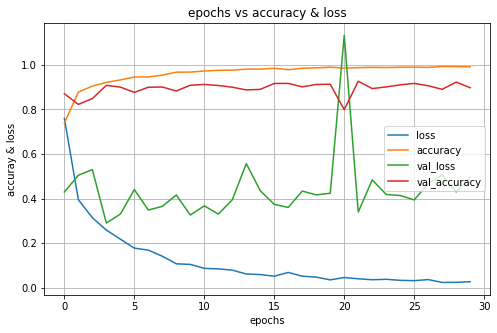

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 23s 218ms/step - loss: 0.4954 - accuracy: 0.8978


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

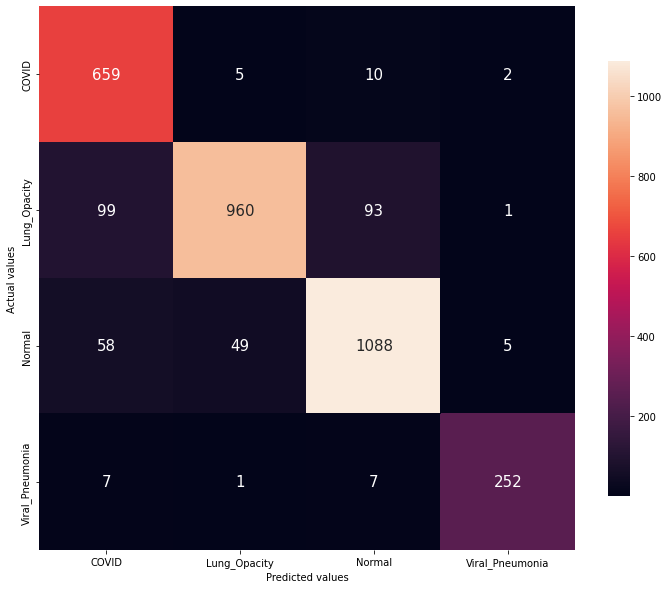

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.80      0.97      0.88       676
   Lung_Opacity       0.95      0.83      0.89      1153
         Normal       0.91      0.91      0.91      1200
Viral_Pneumonia       0.97      0.94      0.96       267

       accuracy                           0.90      3296
      macro avg       0.91      0.91      0.91      3296
   weighted avg       0.90      0.90      0.90      3296

